# Notebook for enriching protein-biological process and drug-biological process edges

In our MOA project, we want to use the [Gene Ontology Biological Process](http://geneontology.org/docs/ontology-documentation/) (BP) as sink nodes, so we need to incorporate this information into the KG.

In [1]:
import pandas as pd
from tqdm import tqdm
import os.path as osp

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import networkx as nx

# Load enriched KG file

In [2]:
KG_DIR = '../data/kg/'

In [3]:
full_kg = pd.read_csv(osp.join(KG_DIR, 'enriched_kg.tsv'), sep='\t')

Get all of the true drug-BP pairs:

In [4]:
true_pairs = [(row['source'], row['target']) for i, row in full_kg.loc[full_kg['edge_type'] == 'induces'].iterrows()]

Get all of the proteins which go to BPs:

In [5]:
bps_in_pairs = {row['target'] for i, row in full_kg.loc[full_kg['edge_type'] == 'induces'].iterrows()}

prots_to_bps = set()

# get the proteins which interact with those BPs
for i, row in full_kg.loc[(full_kg['edge_type'] == 'participates') & (full_kg['target'].isin(bps_in_pairs))].iterrows():
    prots_to_bps.add((row['source']))

len(prots_to_bps)

1816

Add all of the forward PPIs:

In [6]:
G = nx.DiGraph()

for i, row in full_kg.iterrows():
    if row['edge_type'] == 'interacts':
        src_id = row['source']
        trgt_id = row['target']
        if src_id not in G.nodes:
            G.add_node(src_id, type=row['source_node_type'])
        if trgt_id not in G.nodes:
            G.add_node(trgt_id, type=row['target_node_type'])
        G.add_edge(src_id, trgt_id, type=row['edge_type'])

Here, we subset the PPIs in the graph until they are below the limit. We do this systematically by removing PPIs from high-degree edges.

In [7]:
PPI_LIMIT = 20000

In [8]:
prot_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Gene"]
count = 0

while G.number_of_edges() > PPI_LIMIT:
    prot_with_highest_degree = max(prot_nodes, key=lambda n: G.out_degree(n))
    # Find the neighbor of prot_with_highest_degree with the largest degree
    neighbor_of_highest_degree = max([node for node in nx.neighbors(G,prot_with_highest_degree) if node in prot_nodes],
                                      key=lambda n: G.out_degree(n))
    # remove the edge between prot_with_highest_degree and neighbor_of_highest_degree
    G.remove_edge(prot_with_highest_degree, neighbor_of_highest_degree)
    count += 1
    if count % 1000 == 0:
        print(count, G.number_of_edges())

1000 36984
2000 35984
3000 34984
4000 33984
5000 32984
6000 31984
7000 30984
8000 29984
9000 28984
10000 27984
11000 26984
12000 25984
13000 24984
14000 23984
15000 22984
16000 21984
17000 20984


Let's see which proteins are left with a degree of zero:

In [9]:
prots_with_0_degree = [node for node in prot_nodes if G.degree(node) == 0]
len(prots_with_0_degree)

518

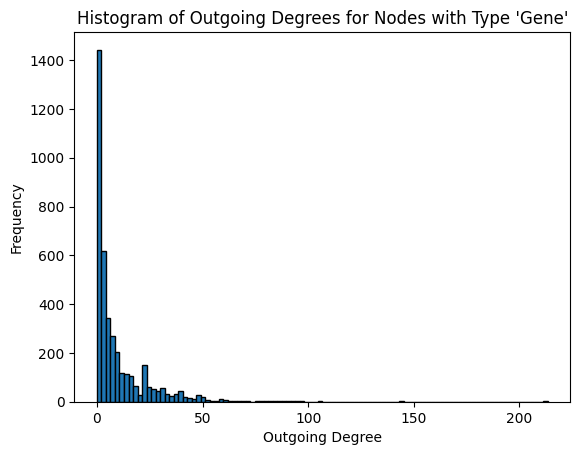

In [10]:
# Filter nodes based on type
prot_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Gene"]

# Calculate outgoing degrees of compound nodes
out_degrees = [G.degree(node) for node in prot_nodes]

# Plot histogram
plt.hist(out_degrees, bins=100, range=(0, max(out_degrees) + 0.5), edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees for Nodes with Type 'Gene'")
plt.show()

In [11]:
degrees = dict(Counter(out_degrees))

for d in sorted(degrees)[0:150]:
    print(d, degrees[d])

0 518
1 570
2 355
3 209
4 409
5 190
6 152
7 128
8 140
9 102
10 101
11 77
12 42
13 62
14 52
15 37
16 32
17 37
18 36
19 30
20 12
21 15
22 39
23 111
24 23
25 37
26 30
27 21
28 22
29 20
30 19
31 20
32 19
33 13
34 17
35 10
36 15
37 21
38 10
39 25
40 19
41 7
42 11
43 7
44 9
45 4
46 8
47 15
48 6
49 8
50 7
51 13
52 4
53 4
54 3
55 2
56 3
57 2
58 6
59 6
60 7
61 1
62 1
63 3
65 1
66 1
68 1
70 1
71 1
72 2
75 1
76 1
77 1
78 1
79 1
80 2
82 1
84 2
85 1
87 1
89 3
90 2
91 1
92 1
94 1
97 1
105 1
106 1
144 1
213 4


We will remove those isolated nodes.

In [12]:
# remove isolated nodes
def remove_isolated_nodes(G):

    # remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    
    return G

In [13]:
G = remove_isolated_nodes(G)

Add in the other edges:

In [14]:
for i, row in full_kg.iterrows():
    if row['edge_type'] != 'interacts':
        src_id = row['source']
        trgt_id = row['target']
        if src_id not in G.nodes:
            G.add_node(src_id, type=row['source_node_type'])
        if trgt_id not in G.nodes:
            G.add_node(trgt_id, type=row['target_node_type'])
        G.add_edge(src_id, trgt_id, type=row['edge_type'])

In [15]:
isolated_nodes = list(nx.isolates(G))
len(isolated_nodes)

0

In [16]:
# export G to pandas df with node types
G_df = nx.to_pandas_edgelist(G, edge_key='edge_type')

In [17]:
G_df.rename(columns={'type': 'edge_type'}, inplace=True)

In [18]:
G_df

,source,target,edge_type
0,ncbigene:6622,ncbigene:3308,interacts
1,ncbigene:6622,ncbigene:10273,interacts
2,ncbigene:6622,ncbigene:1861,interacts
3,ncbigene:6622,GO:0043065,participates
4,ncbigene:3308,ncbigene:6767,interacts
...,...,...,...
28039,ncbigene:390882,GO:0007165,participates
28040,ncbigene:390883,GO:0007165,participates
28041,ncbigene:390892,GO:0007165,participates
28042,ncbigene:392390,GO:0007165,participates


In [19]:
def map_to_nodetype(id):
    if 'ncbigene:' in id:
        return 'Gene'
    elif 'GO:' in id:
        return 'Biological Process'
    elif 'pubchem' in id:
        return 'Compound'
    else:
        raise ValueError(f'Unknown node type for {id}')

In [20]:
G_df['source_node_type'] = [map_to_nodetype(i) for i in G_df['source']]
G_df['target_node_type'] = [map_to_nodetype(i) for i in G_df['target']]

In [21]:
G_df

,source,target,edge_type,source_node_type,target_node_type
0,ncbigene:6622,ncbigene:3308,interacts,Gene,Gene
1,ncbigene:6622,ncbigene:10273,interacts,Gene,Gene
2,ncbigene:6622,ncbigene:1861,interacts,Gene,Gene
3,ncbigene:6622,GO:0043065,participates,Gene,Biological Process
4,ncbigene:3308,ncbigene:6767,interacts,Gene,Gene
...,...,...,...,...,...
28039,ncbigene:390882,GO:0007165,participates,Gene,Biological Process
28040,ncbigene:390883,GO:0007165,participates,Gene,Biological Process
28041,ncbigene:390892,GO:0007165,participates,Gene,Biological Process
28042,ncbigene:392390,GO:0007165,participates,Gene,Biological Process


In [22]:
Counter(G_df['edge_type'])

Counter({'interacts': 20000,
         'participates': 2571,
         'downregulates': 2178,
         'induces': 1675,
         'upregulates': 1620})

But we've got to take out any drug-BP pairs which can no longer be matched:

In [23]:
edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if 'type' in data and data['type'] == 'induces']
G.remove_edges_from(edges_to_remove)

In [24]:
no_path = set()

for pair in true_pairs:
    path_exists = nx.has_path(G, pair[0], pair[1])
    if not path_exists:
        no_path.add(pair)

print(len(no_path))

399


In [25]:
len(true_pairs)

1675

In [26]:
len(no_path) / len(true_pairs)

0.2382089552238806

In [27]:
for i, row in G_df.iterrows():
    if row['edge_type'] == 'induces' and (row['source'], row['target']) in no_path:
        print(f"Dropping {(row['source'], row['target'])}")
        G_df.drop(i, inplace=True)

Dropping ('pubchem.compound:10607', 'GO:0021700')
Dropping ('pubchem.compound:10607', 'GO:0022618')
Dropping ('pubchem.compound:10631', 'GO:0021700')
Dropping ('pubchem.compound:11707110', 'GO:0040011')
Dropping ('pubchem.compound:124087', 'GO:0040011')
Dropping ('pubchem.compound:12560', 'GO:0009820')
Dropping ('pubchem.compound:126941', 'GO:0006520')
Dropping ('pubchem.compound:126941', 'GO:0009790')
Dropping ('pubchem.compound:126941', 'GO:0022618')
Dropping ('pubchem.compound:126941', 'GO:0021700')
Dropping ('pubchem.compound:126941', 'GO:0040011')
Dropping ('pubchem.compound:15209', 'GO:0021700')
Dropping ('pubchem.compound:15209', 'GO:0022618')
Dropping ('pubchem.compound:16362', 'GO:0040011')
Dropping ('pubchem.compound:2265', 'GO:0006259')
Dropping ('pubchem.compound:2265', 'GO:0007165')
Dropping ('pubchem.compound:2265', 'GO:0022607')
Dropping ('pubchem.compound:2265', 'GO:0050790')
Dropping ('pubchem.compound:2265', 'GO:0051276')
Dropping ('pubchem.compound:2265', 'GO:0007155

In [28]:
Counter(G_df['edge_type'])

Counter({'interacts': 20000,
         'participates': 2571,
         'downregulates': 2178,
         'upregulates': 1620,
         'induces': 1276})

In [29]:
G_df

,source,target,edge_type,source_node_type,target_node_type
0,ncbigene:6622,ncbigene:3308,interacts,Gene,Gene
1,ncbigene:6622,ncbigene:10273,interacts,Gene,Gene
2,ncbigene:6622,ncbigene:1861,interacts,Gene,Gene
3,ncbigene:6622,GO:0043065,participates,Gene,Biological Process
4,ncbigene:3308,ncbigene:6767,interacts,Gene,Gene
...,...,...,...,...,...
28039,ncbigene:390882,GO:0007165,participates,Gene,Biological Process
28040,ncbigene:390883,GO:0007165,participates,Gene,Biological Process
28041,ncbigene:390892,GO:0007165,participates,Gene,Biological Process
28042,ncbigene:392390,GO:0007165,participates,Gene,Biological Process


In [30]:
G_df.to_csv(osp.join(KG_DIR, 'full_kg.tsv'), sep='\t', index=False)